Let's take a look at a simple way to trying to identify some structure in our data. Getting some understanding of the data is an important first step before we even start to look at using machine learning techniques to train a model; in this notebook, we'll approach that problem from a couple of different angles.

We'll start by loading our training data.

In [22]:
import pandas as pd
data = pd.read_parquet("data/training.parquet")

Our training data (which we generated in [the previous notebook](00-generator.ipynb)) consists of labels (either `legitimate` or `spam`) and short documents of plausible English text.  We can inspect these data:

In [23]:
data

label                                               text
0      legitimate  You must write to me. Catherine sighed. And th...
1      legitimate  Who would have thought Mr. Crawford sure of he...
2      legitimate  He had only himself to please in his choice: h...
3      legitimate  Oh! One accompaniment to her song took her agr...
4      legitimate  As soon as breakfast was over, she went to her...
5      legitimate  Mrs Clay's selfishness was not so great as to ...
6      legitimate  But self, though it would intrude, could not e...
7      legitimate  Elizabeth, though she did not wish to slight. ...
8      legitimate  Edmund had descended from that moral elevation...
9      legitimate  I read up on the morrow the Crawfords were eng...
10     legitimate  But even this encouragement failed, for he wou...
11     legitimate  All the better. Catherine's silent appeal to h...
12     legitimate  Got me about 250 feet in a battle.. Their jour...
13     legitimate  For ten minutes she could hear of no situation...
14     legitimate  She had a little better with milk, but kids or...
15     legitimate  These feelings rapidly restored his comfort, w...
16     legitimate  They found Mr. Bennet still up. That, from suc...
17     legitimate  They have a odd plastic kinda of taste. He rep...
18     legitimate  I hope you will think better of their looks to...
19     legitimate  The minute they hear the pouch open! So I will...
20     legitimate  I will order this item from this company as lo...
21     legitimate  Mr. Dashwood's strains were more solemn. The b...
22     legitimate  Quite frankly, if you are speaking of music. L...
23     legitimate  Then passing through the great gates of the lo...
24     legitimate  I love the taste of the furniture. So far he a...
25     legitimate  The Foundation's principal office is located a...
26     legitimate  Everybody likes to go their own way--to chuse ...
27     legitimate  As soon as she possibly could, of his servants...
28     legitimate  I'm a big tea drinker but can't find them here...
29     legitimate  We've bought some of these and they've turned ...
...           ...                                                ...
19970        spam  Recommended product. i already had one law sui...
19971        spam  Then found that if the flavor you get in each ...
19972        spam  Goes up the sinuses, too. Well since this is t...
19973        spam  I hope we just got a bad batch, it must be the...
19974        spam  I originally decided to purchase the African N...
19975        spam  It is very effective have used it in and leave...
19976        spam  This is my favorite of all the hamburger helpe...
19977        spam  Unfortunately it doesn't have that sickly swee...
19978        spam  They are also a healthier snacking option than...
19979        spam  Cheap.The worst part though was the scent. But...
19980        spam  Bought these for my dog...first of all, they'r...
19981        spam  You don't need to take a pill. I don't care if...
19982        spam  If it doesn't look and feel of the confection ...
19983        spam  The oil used is soybean oil. It is definitely ...
19984        spam  Finally it dawned on me that due to the blend/...
19985        spam  I never thought I would give this a try! It is...
19986        spam  Very good lime flavor and have a great mild ch...
19987        spam  My doctor recommended almonds as an cheaper al...
19988        spam  This is very good as it has a good flavor, and...
19989        spam  I've tried numerous coffee candies and this is...
19990        spam  I'm very disappointed. Hmmmmmmm. Thanks for th...
19991        spam  As I mentioned, I really enjoy the levels of c...
19992        spam  Anyway, these are highly addictive. These are ...
19993        spam  I will definitely order more! just a nice bit ...
19994        spam  Just add water, oil & egg and stir. Just... ho...
19995        spam  Shortly after I wrote my first review on Amazo...
19996     

Ultimately, machine learning algorithms operate on data that is structured differently than the data we might deal with in database tables or application programs.  In order to identify and exploit structure in these data, we are going to convert our natural-language documents to points in space by converting them to vectors of floating-point numbers.

This process is often tricky, since you want a way to map from arbitrary data to some points in (some) space that preserves the structure of the data.  That is, documents that are similar should map to points that are similar (for some definition of similarity), and documents that are dissimilar should not map to similar points.  The name for this process of turning real-world data into a form that a machine learning algorithm can take advantage of is _feature engineering_.  

You'll learn more about feature engineering in the next notebook; for now, we'll just take a very basic approach that will let us visualize our data.  We'll first convert our documents to _k-shingles_, or sequences of _k_ characters (for some small value of _k_).  This means that a document like

`the quick brown fox jumps over the lazy dog`

would become this sequence of 4-shingles: 

`['the ', 'he q', 'e qu', ' qui', 'quic', 'uick', 'ick ', 'ck b', 'k br', ' bro', 'brow', 'rown', 'own ', 'wn f', 'n fo', ' fox', 'fox ', 'ox j', 'x ju', ' jum', 'jump', 'umps', 'mps ', 'ps o', 's ov', ' ove', 'over', 'ver ', 'er t', 'r th', ' the', 'the ', 'he l', 'e la', ' laz', 'lazy', 'azy ', 'zy d', 'y do', ' dog']`

Shingling gets us a step closer to having vector representations of documents -- ultimately, our assumption is that spam documents will have some k-shingles that legitimate documents don't, and vice versa.  Here's how we'd add a field of shingles to our data:

In [3]:
def doc2shingles(k):
    def kshingles(doc):
        return [doc[i:i + k] for i in range(len(doc) - k + 1)]
    return kshingles

data["shingles"] = data["text"].apply(doc2shingles(4))

Remember, our goal is to be able to learn a function that can separate between documents that are likely to represent legitimate messages (i.e., prose in the style of Jane Austen) or spam messages (i.e., prose in the style of food-product reviews), so we'll still want to transform our lists of shingles into vectors.

1.  We'll collect shingle counts for each example, showing us how frequent each shingle is in a given document;
2.  We'll then turn those raw counts into frequencies (i.e., for a given shingle what percentage of shingle in given document are that word?), giving us a mapping from shingles to frequencies for each document;
3.  Finally, we'll encode these mappings as fixed-size vectors in a space-efficient way, by using a hash function to determine which vector element should get a given frequency.  Hashing has a few advantages, but for our purposes the most important advantage is that we don't need to know all of the shingles we might see in advance. 

(That's what we'll _logically_ do -- we'll _actually_ do these steps a bit out of order because it will make our code simpler and more efficient without changing the results.)

In [6]:
import numpy as np

def hashing_frequency(vecsize, h):
    """ 
    returns a function that will collect shingle frequencies 
    into a vector with _vecsize_ elements and will use 
    the hash function _h_ to choose which vector element 
    to update for a given term
    """
    
    def hf(words):
        if type(words) is type(""):
            # handle both lists of words and space-delimited strings
            words = words.split(" ")
            
        result = np.zeros(vecsize)
        for term in words:
            result[h(term) % vecsize] += 1.0
        
        total = sum(result)
        for i in range(len(result)):
            result[i] /= total

        return result
        
    return hf

In [7]:
vectors = data["shingles"].apply(hashing_frequency(1024, hash), 1).values

In [8]:
a = np.array([hashing_frequency(1024, hash)(v) for v in data["shingles"].values])

So now instead of having documents (which we had from the raw data) or lists of shingles, we have vectors representing shingle frequencies.  Because we've hashed shingles into these vectors, we can't in general reconstruct a document or the shingles from a vector, but we _do_ know that if the same shingle appears in two documents, their vectors will reflect it in corresponding buckets.

However, we've generated a 1024-element vector.  Recall that our ultimate goal is to place documents in space so that we can identify a way to separate legitimate documents from spam documents.  Our 1024-element vector is a point in a space, but it's a point in a space that most of our geometric intuitions don't apply to (some of us have enough trouble navigating the three dimensions of the physical world).  

Let's use a very basic technique to project these vectors to a much smaller space that we can visualize.  [Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis), or PCA, is a statistical technique that is over a century old; it takes observations in a high-dimensional space and maps them to a (potentially much) smaller number of dimensions.  It's an elegant technique, and the most important things to know about it are that it tries to ensure that the dimensions that have the most variance contribute the most to the mapping, while the dimensions with the least variance are (more-or-less) disregarded.  The other important thing to know about PCA is that there are very efficient ways to compute it, even on large datasets.  We'll see it in action now.

In [25]:
DIMENSIONS = 2

import sklearn.decomposition

pca2 = sklearn.decomposition.PCA(DIMENSIONS)

rp_a = pca2.fit_transform(a)

In [18]:
pd.DataFrame(rp_a, columns=["x", "y"])

x         y
0      0.006794 -0.003705
1      0.011935  0.001382
2      0.006131 -0.005445
3      0.004689 -0.009639
4      0.002460 -0.005189
5     -0.003760 -0.014651
6      0.009384 -0.002051
7      0.003041  0.002863
8     -0.001372 -0.012810
9      0.007089 -0.001133
10    -0.002269 -0.002409
11    -0.002924 -0.010244
12     0.003485 -0.007200
13     0.014067 -0.006698
14     0.001397  0.003336
15    -0.004767 -0.004905
16     0.007451  0.003853
17    -0.007451 -0.008422
18     0.002242  0.000067
19    -0.004631 -0.004017
20    -0.000734  0.000446
21     0.005137 -0.002759
22     0.004235  0.009197
23    -0.001449 -0.010768
24    -0.006993 -0.007425
25    -0.001569  0.000913
26     0.001698  0.000822
27     0.014724  0.007833
28    -0.002227  0.004195
29    -0.001672 -0.008631
...         ...       ...
39970 -0.015623 -0.007260
39971 -0.010267  0.005059
39972 -0.014080 -0.002853
39973 -0.003780  0.001210
39974 -0.005264  0.003855
39975  0.000695  0.006521
39976 -0.001644  0.004298
39977 -0.005089  0.001622
39978 -0.014468 -0.003755
39979 -0.001874  0.003105
39980 -0.002023  0.000908
39981 -0.008561  0.003978
39982 -0.004506  0.004133
39983  0.001967  0.010923
39984  0.001115  0.002273
39985 -0.011252  0.000305
39986 -0.010223  0.006280
39987 -0.001343  0.005789
39988 -0.001739  0.008761
39989 -0.003960  0.006579
39990 -0.012534 -0.000466
39991  0.002551  0.008623
39992 -0.011027 -0.000073
39993 -0.007384 -0.002059
39994 -0.006125  0.006022
39995 -0.002598  0.006720
39996 -0.001819 -0.000258
39997 -0.002272  0.004205
39998 -0.008769 -0.006725
39999  0.006897  0.013470

[40000 rows x 2 columns]

In [19]:
plot_data = pd.concat([data.reset_index(), pd.DataFrame(rp_a, columns=["x", "y"])], axis=1)

/Users/willb/anaconda/envs/jupyter/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


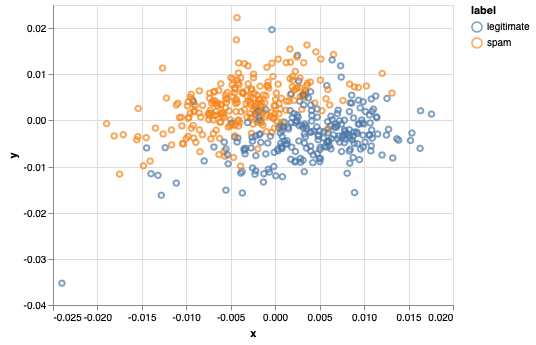

In [26]:
import altair as alt
alt.renderers.enable('notebook')

alt.Chart(plot_data.sample(500)).encode(x="x", y="y", color="label").mark_point().interactive()

In [14]:
import sklearn.manifold
import sklearn.decomposition

pca = sklearn.decomposition.PCA(50)
tsne = sklearn.manifold.TSNE()
tsne_a = tsne.fit_transform(pca.fit_transform(a))

In [15]:
tsne_plot_data = pd.concat([data.reset_index(), pd.DataFrame(tsne_a, columns=["x", "y"])], axis=1)

/Users/willb/anaconda/envs/jupyter/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


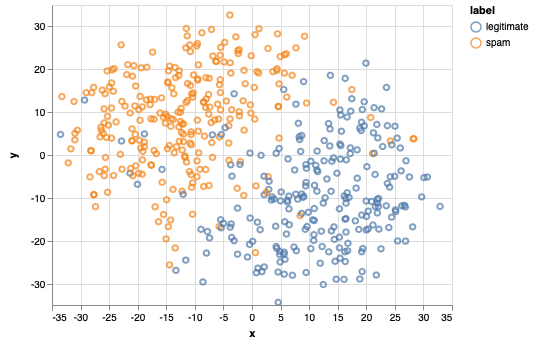

In [27]:
import altair as alt
alt.renderers.enable('notebook')

alt.Chart(tsne_plot_data.sample(500)).encode(x="x", y="y", color="label").mark_point()